In [29]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
from tqdm import tqdm
import numpy as np
from PIL import Image
from csbdeep.utils import normalize
import tifffile as tiff
import pandas as pd
from matplotlib.lines import Line2D

sys.path.append(str(Path("..").resolve()))
from src import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate a Better Trainset
The trainset is made of couples of `noisy`-`cleaned` images. This time, no normalization is performed and no info is lost due to casting. Images are saved as 16bit grayscale.

- The `noisy` image is the noisy input.
- The `clean` image is the one denoised with DeepCAD-RT or the like.

In [5]:
DATASET_NAME="oabf_astro"

In [6]:
mot_cor = tiff.imread(str(DATASETS[DATASET_NAME] / "x.tiff"), key=range(0, 1_000))
deepcad = tiff.imread(str(DATASETS[DATASET_NAME] / "y.tiff"), key=range(0, 1_000))

## 1. Normalizing Data
Albeit not mandatory, it's common practice to normalize data distribution across all the recordings. **It's important to consider data as a whole when computing aggregated values like the 99.99% percentile or the maximum value.**

As shown below, the DeepCAD cleaned TIFF has a scaling factor of $\approx 0.526$ compared to the noisy footage.

In [88]:
mot_cor_max=pd.Series((mot_cor).flatten()).quantile(0.9999).item()
deepcad_max=pd.Series((deepcad).flatten()).quantile(0.9999).item()
cprint("Motion Corrected 99.99% percentile -->",f"red:{mot_cor_max:,.0f}")
cprint("DeepCAD-RT 99.99% percentile -->",f"red:{deepcad_max:,.0f}")

Motion Corrected 99.99% percentile --> 14,207
DeepCAD-RT 99.99% percentile --> 6,521


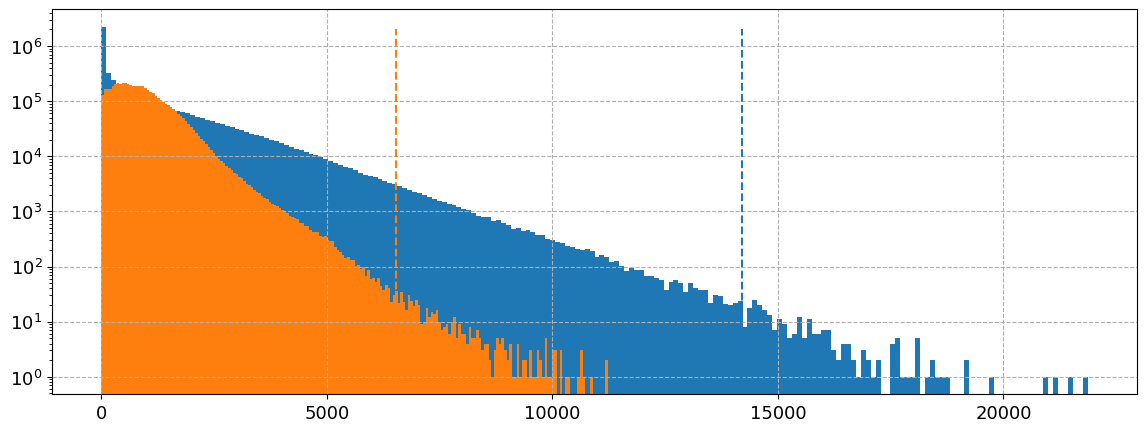

In [89]:
ax = pd.Series(mot_cor[::50].flatten()).hist(bins=200, figsize=(14, 5))
pd.Series((deepcad[::50]).flatten()).hist(bins=200, ax=ax)
ax.add_line(Line2D([mot_cor_max, mot_cor_max], [0, 2e6], linestyle="--", color="tab:blue"))
ax.add_line(Line2D([deepcad_max, deepcad_max], [0, 2e6], linestyle="--", color="tab:orange"))
plt.yscale("log")

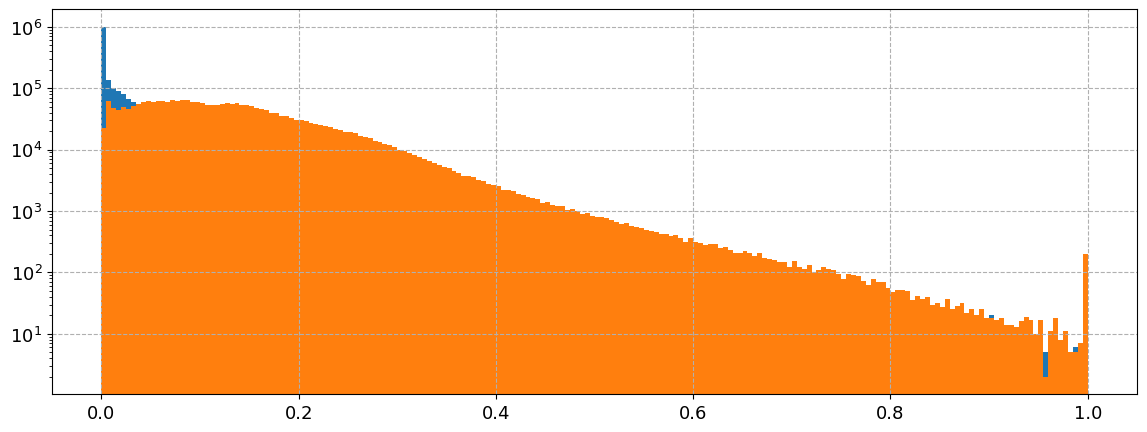

In [87]:
ax = pd.Series(np.clip(mot_cor[::100]/mot_cor_max, min=0, max=1).flatten()).hist(bins=200, figsize=(14, 5))
pd.Series(np.clip(deepcad[::100]/deepcad_max, min=0, max=1).flatten()).hist(bins=200, ax=ax)
plt.yscale("log")

Note that this found values are not used here since the frames are saved as `uint16` PNG files. They are employed in the [`npy2tensor`](../src/dataset/dataset.py) function, when images are converted to [-1,1] tensors.

### How to read the 16bit greyscale PNG back?

In [9]:
np.array(Image.open("dataset/oabf_astro/clean/0.png")).dtype

dtype('uint16')

The dtype must be `uint16`. This means no info is lost due to quantization.

## 2. Generate samples
**This part isn't really needed**. `Dataset`'s subclasses can load the *TIFF* files directly, without requiring additional space on disk. I'll leave it as it is just in case.

In [ ]:
noisy_dir = Path(f"dataset/{DATASET_NAME}/noisy")
cond_dir = Path(f"dataset/{DATASET_NAME}/clean")
noisy_dir.mkdir(exist_ok=True, parents=True)
cond_dir.mkdir(exist_ok=True, parents=True)

In [5]:
# >1m
for i in tqdm(range(6940, mot_cor.shape[0])):
    noisy, clean = mot_cor[i], deepcad[i]
    Image.fromarray(noisy).convert("I;16").save(noisy_dir / f"{i}.png")
    Image.fromarray(clean).convert("I;16").save(cond_dir / f"{i}.png")

100%|██████████| 3060/3060 [02:19<00:00, 21.91it/s]
